In [1]:
# Installs all of the libraries present in the 'offline-pytorch-2-1-2' dataset
!pip install \
   --requirement /kaggle/input/offline-pytorch-2-1-2/requirements.txt \
   --no-index \
   --find-links file:///kaggle/input/offline-pytorch-2-1-2/wheels  \
--q

In [2]:
import os
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [3]:
import koilerplate
print(f"koilerplate: {koilerplate.__version__}")

import torch
print(f"torch: {torch.__version__}")

import torchvision
print(f"torchvision: {torchvision.__version__}")

import torchaudio
print(f"torchaudio: {torchaudio.__version__}")

import torchdata
print(f"torchdata: {torchdata.__version__}")

import torchtext
print(f"torchtext: {torchtext.__version__}")

koilerplate: 0.1.3
torch: 2.1.2+cu118
torchvision: 0.16.2+cu118
torchaudio: 2.1.2+cu118
torchdata: 0.7.1+cpu
torchtext: 0.16.2+cpu


In [4]:
!pip install pycocotools --quiet

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed

import pandas as pd # data processing
import numpy as np
# Data Visulization libraries 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torchvision.io import read_image
from torchvision.tv_tensors import BoundingBoxes, Image
from torchvision.transforms.v2 import functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
files_dir = '/kaggle/input/bts-members-detection/images'

In [7]:
temp1 = ['/'+image for image in sorted(os.listdir(files_dir))
                        if (image[-4:]=='.png') and (image[:-4]+'.txt' in os.listdir(files_dir))
         and os.path.getsize(files_dir+'/'+image[:-4]+'.txt') != 0]
temp2 = ['/'+annot for annot in sorted(os.listdir(files_dir))
                        if (annot[-4:]=='.txt') and os.path.getsize(files_dir+'/'+annot) != 0]

images = pd.Series(temp1, name='images')
image_id = pd.Series(list(range(len(temp1))), name='id')
train_img_df = pd.DataFrame(pd.concat([images, image_id], axis=1))
images = []
image_id = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for j in range(len(file.readlines())):
            images.append(temp1[i])
            image_id.append(i)
        file.close()
bboxes = []
for i in range(len(temp1)):
    with open(files_dir + temp2[i], 'r') as file:
        for line in file.readlines():
            bboxes.append(list(map(float, line.split())))
        file.close()
images = pd.Series(images, name='images')
bboxes = pd.Series(bboxes, name='bboxes')
image_id = pd.Series(image_id, name='image_id')
ind = pd.Series(list(range(len(images))), name='id')
df = pd.concat([images, ind,image_id,bboxes], axis=1)
train_df = pd.DataFrame(df)
area = []
for i in range(train_df.shape[0]):
    img_path = files_dir + train_df.iloc[i,0]
    img = read_image(img_path)
    area.append(train_df.iloc[i,3][3]*train_df.iloc[i,3][4])
train_df = pd.concat([train_df, pd.Series(area, name='area')],axis=1)

In [8]:
train_df.head()

,images,id,image_id,bboxes,area
0,/jhope0.png,0,0,"[0.0, 0.497253, 0.289855, 0.467033, 0.543478]",0.253822
1,/jhope1.png,1,1,"[0.0, 0.477778, 0.391111, 0.848889, 0.782222]",0.664020
2,/jhope10.png,2,2,"[0.0, 0.4, 0.393333, 0.408889, 0.44]",0.179911
3,/jhope100.png,3,3,"[0.0, 0.555184, 0.446429, 0.622074, 0.892857]",0.555423
4,/jhope101.png,4,4,"[0.0, 0.52901, 0.319767, 0.361775, 0.639535]",0.231368


In [9]:
train_df.shape, train_img_df.shape

((809, 5), (808, 2))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
#train, valid, train_img, valid_img = train_df.iloc[:int(809*0.6), :], train_df.iloc[int(809*0.6):, :], train_img_df.iloc[:int(809*0.6), :], train_img_df.iloc[int(809*0.6):, :]

# 0 - Dataset

In [12]:
import os
import torch

class BTSDataset(torch.utils.data.Dataset):
    def __init__(self, root, images_dataset, boxes_dataset, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.dataset = images_dataset
        self.boxes_dataset = boxes_dataset

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.root + self.dataset.query('id == @idx').images[idx]
        boxes_query = self.boxes_dataset.query('image_id == @idx')
        boxes_list = list(boxes_query.bboxes.iloc[i][1:] for i in range(boxes_query.bboxes.shape[0]))
        labels_list = list(boxes_query.bboxes.iloc[i][0] + 1 for i in range(boxes_query.bboxes.shape[0]))
        img = read_image(img_path)
        boxes = torch.tensor(boxes_list)
        #print(img_path)
        for box in boxes:
            box[0], box[1], box[2], box[3] = \
            box[0]*F.get_size(img)[1], box[1]*F.get_size(img)[0], \
            box[2]*F.get_size(img)[1], box[3]*F.get_size(img)[0]
        boxes = torchvision.ops.box_convert(boxes, 'cxcywh', 'xyxy')
        labels = torch.tensor(labels_list, dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        
        # Wrap sample and targets into torchvision tv_tensors:
        img = Image(img)

        target = {}
        target["boxes"] = BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.dataset)

# 2 - Modifying the model to add a different backbone

In [13]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [14]:
import torch.utils as utils
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate

def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    return [data, target]

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
# our dataset has two classes only - background and person
num_classes = 7+1
# use our dataset and defined transformations
images_dataset = train_img_df
boxes_dataset = train_df
dataset = BTSDataset(root='/kaggle/input/bts-members-detection/images',
                     images_dataset=images_dataset, 
                     boxes_dataset=boxes_dataset, 
                     transforms=get_transform(train=True))
'''dataset_test = BTSDataset(root='/kaggle/input/bts-members-detection/images',
                     images_dataset=valid_img, 
                     boxes_dataset=valid, 
                     transforms=get_transform(train=False))'''



# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=12,
    shuffle=True,
    collate_fn=my_collate
)

'''data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=my_collate
)'''


# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=1e-2,
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=7,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 93.4MB/s]


Epoch: [0]  [ 0/68]  eta: 0:01:24  lr: 0.000159  loss: 1.1298 (1.1298)  loss_classifier: 0.7300 (0.7300)  loss_box_reg: 0.2226 (0.2226)  loss_objectness: 0.1000 (0.1000)  loss_rpn_box_reg: 0.0772 (0.0772)  time: 1.2373  data: 0.0948  max mem: 5629
Epoch: [0]  [67/68]  eta: 0:00:00  lr: 0.010000  loss: 17952344.0000 (37805353322.9859)  loss_classifier: 607738.0000 (8371278176.2227)  loss_box_reg: 1453739.3750 (28844253658.6051)  loss_objectness: 540630.6250 (187050178.8346)  loss_rpn_box_reg: 729030.1875 (402773376.2803)  time: 0.4761  data: 0.0625  max mem: 6467
Epoch: [0] Total time: 0:00:39 (0.5786 s / it)
Epoch: [1]  [ 0/68]  eta: 0:00:32  lr: 0.010000  loss: 397157504.0000 (397157504.0000)  loss_classifier: 4.2605 (4.2605)  loss_box_reg: 0.0956 (0.0956)  loss_objectness: 50318920.0000 (50318920.0000)  loss_rpn_box_reg: 346838592.0000 (346838592.0000)  time: 0.4837  data: 0.0689  max mem: 6467
Epoch: [1]  [67/68]  eta: 0:00:00  lr: 0.010000  loss: 35073044.0000 (24795309288616.5078)

In [15]:
from torchvision.ops import nms

path_img = "/kaggle/input/bts-members-detection/images/jhope116.png"
image = read_image(path_img)
eval_transform = get_transform(train=False)
model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x.to(device)
    
    predictions = model([x, ])
    print(predictions)
    pred = predictions[0]
    print(pred)
    result = nms(pred['boxes'], pred['scores'], iou_threshold=0.1).to('cpu')
    pred = {'labels': pred['labels'][result], 
            'scores': pred['scores'][result], 
            'boxes': pred['boxes'][result, :]}
print(pred)

[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
{'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0'), 'boxes': tensor([], device='cuda:0', size=(0, 4))}


In [16]:
names = sorted(['jhope', 'jimin', 'jin', 'suga', 'jungkook', 'rm', 'v'])
class_names = dict((i, names[i]) for i in range(7))

In [17]:
print(class_names)

{0: 'jhope', 1: 'jimin', 2: 'jin', 3: 'jungkook', 4: 'rm', 5: 'suga', 6: 'v'}


/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


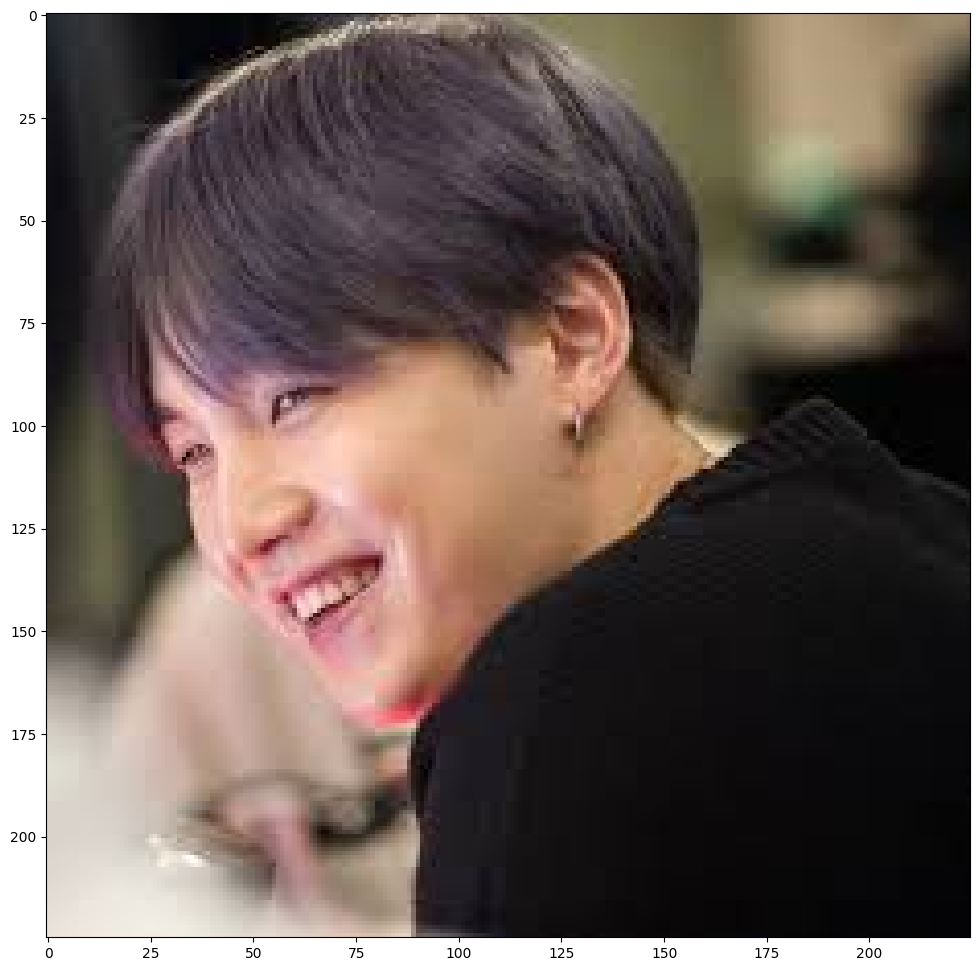

In [18]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

path_img = "/kaggle/input/korean-band-bts-members-face-recognition/images/suga/suga46.png"
image = read_image(path_img)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    '''pred['boxes'][..., [0, 2]] -= pred['boxes'][..., [2, 0]].diff(axis=1)/2
    pred['boxes'][..., [1, 3]] -= pred['boxes'][..., [3, 1]].diff(axis=1)/2'''
    result = nms(pred['boxes'], pred['scores'], iou_threshold=0.01).to('cpu')
    pred = {'labels': pred['labels'][result], 
            'scores': pred['scores'][result], 
            'boxes': pred['boxes'][result, :]}
#image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red",width=3, \
                                   font = '../input/synth-indic-custom-resources/SYNTH_INDIC/fonts/english/English.ttf',\
                                   font_size = 20)


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}


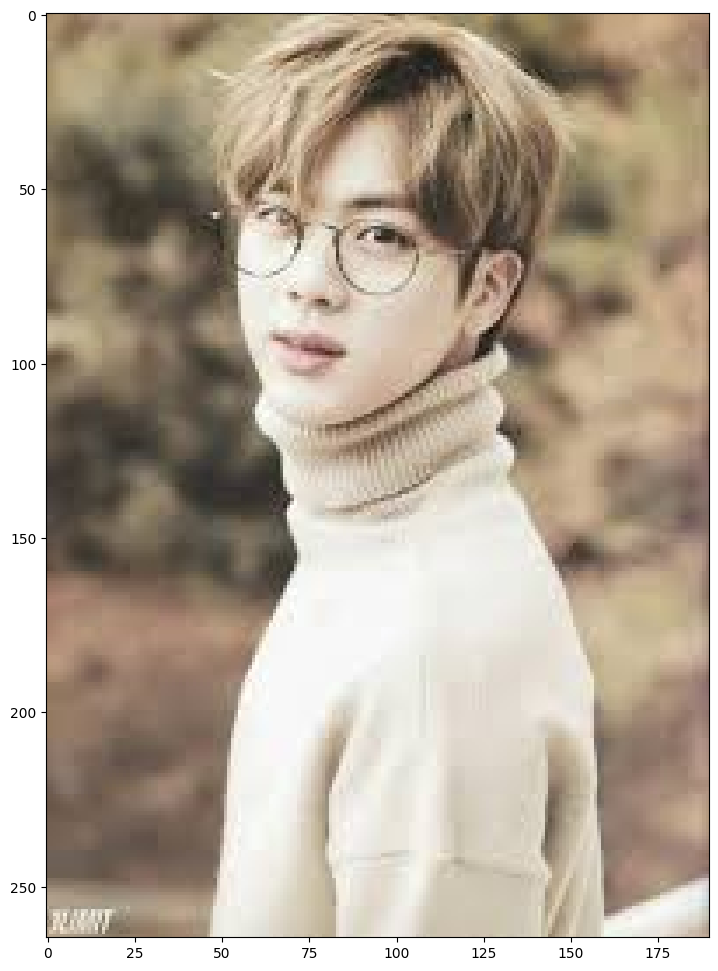

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

path_img = "/kaggle/input/korean-band-bts-members-face-recognition/images/jin/jin99.png"
image = read_image(path_img)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    print(pred)
    result = nms(pred['boxes'], pred['scores'], iou_threshold=0.1).to('cpu')
    pred = {'labels': pred['labels'][result], 
            'scores': pred['scores'][result], 
            'boxes': pred['boxes'][result, :]}


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red",width=3, \
                                   font = '../input/synth-indic-custom-resources/SYNTH_INDIC/fonts/english/English.ttf',\
                                   font_size = 20)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))